# FMCG Data Analytics

## Import Dependencies

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
import xgboost as xgb

## Download the Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("beatafaron/fmcg-daily-sales-data-to-2022-2024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hisma\.cache\kagglehub\datasets\beatafaron\fmcg-daily-sales-data-to-2022-2024\versions\16


## Load the Dataset

In [3]:
fmcg_dataset = pd.read_csv(path + "\\FMCG_2022_2024.csv", parse_dates=["date"])

## Overview

### Original Dataset

In [4]:
fmcg_dataset.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


### Quick Overview

In [5]:
fmcg_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190757 entries, 0 to 190756
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             190757 non-null  datetime64[ns]
 1   sku              190757 non-null  object        
 2   brand            190757 non-null  object        
 3   segment          190757 non-null  object        
 4   category         190757 non-null  object        
 5   channel          190757 non-null  object        
 6   region           190757 non-null  object        
 7   pack_type        190757 non-null  object        
 8   price_unit       190757 non-null  float64       
 9   promotion_flag   190757 non-null  int64         
 10  delivery_days    190757 non-null  int64         
 11  stock_available  190757 non-null  int64         
 12  delivered_qty    190757 non-null  int64         
 13  units_sold       190757 non-null  int64         
dtypes: datetime64[ns](1)

In [6]:
fmcg_dataset.isna().sum()

date               0
sku                0
brand              0
segment            0
category           0
channel            0
region             0
pack_type          0
price_unit         0
promotion_flag     0
delivery_days      0
stock_available    0
delivered_qty      0
units_sold         0
dtype: int64

In [7]:
print(f"{fmcg_dataset["category"].nunique()} Unique Categories:")
print(fmcg_dataset["category"].unique())

print(f"\n{fmcg_dataset["brand"].nunique()} Unique Brands:")
print(fmcg_dataset["brand"].unique())

print(f"\n{fmcg_dataset["sku"].nunique()} Unique SKUs:")
print(fmcg_dataset["sku"].unique())

print(f"\n{fmcg_dataset["region"].nunique()} Regions of Poland:")
print(fmcg_dataset["region"].unique())

print(f"\n{fmcg_dataset["channel"].nunique()} Sales Channels:")
print(fmcg_dataset["channel"].unique())

5 Unique Categories:
['Milk' 'Yogurt' 'ReadyMeal' 'Juice' 'SnackBar']

14 Unique Brands:
['MiBrand1' 'MiBrand4' 'YoBrand4' 'YoBrand2' 'YoBrand1' 'YoBrand3'
 'ReBrand1' 'ReBrand4' 'MiBrand3' 'JuBrand3' 'SnBrand2' 'ReBrand2'
 'SnBrand3' 'MiBrand2']

30 Unique SKUs:
['MI-006' 'MI-026' 'YO-029' 'YO-005' 'YO-012' 'YO-014' 'YO-001' 'RE-004'
 'RE-007' 'RE-015' 'MI-023' 'JU-021' 'YO-009' 'SN-027' 'YO-003' 'MI-022'
 'YO-016' 'RE-025' 'SN-010' 'RE-017' 'SN-013' 'YO-020' 'SN-019' 'MI-002'
 'MI-011' 'YO-024' 'MI-008' 'SN-028' 'YO-018' 'SN-030']

3 Regions of Poland:
['PL-Central' 'PL-North' 'PL-South']

3 Sales Channels:
['Retail' 'Discount' 'E-commerce']


### Simple Sorting and Review

In [8]:
fmcg_dataset.sort_values(by=["date", "category", "brand", "segment", "sku", "region", "channel"])
fmcg_dataset.reset_index(drop=True, inplace=True)
fmcg_dataset.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


## Feature Engineering

### Chunking Date

In [9]:
def chunking_date(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe["year"] = dataframe["date"].dt.year
    dataframe["month"] = dataframe["date"].dt.month_name()
    dataframe["week"] = dataframe["date"].dt.isocalendar().week
    dataframe["day_of_the_month"] = dataframe["date"].dt.day
    dataframe["day_of_the_week"] = dataframe["date"].dt.day_name()

    return dataframe

In [10]:
fmcg_dataset = chunking_date(fmcg_dataset)

### Categorize Weekday-Weekend

In [11]:
def categorize_weekend(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe["is_weekend"] = fmcg_dataset["day_of_the_week"].isin(["Saturday", "Sunday"])

    return dataframe

In [12]:
fmcg_dataset = categorize_weekend(fmcg_dataset)

### Season-Month Mapping

In [13]:
def season_month_mapping(dataframe: pd.DataFrame) -> pd.DataFrame:
    # Based on https://www.timeanddate.com/calendar/seasons.html?n=262
    season_month_pair = {
        "January": "Winter", "February": "Winter", "March": "Spring", "April": "Spring",
        "May": "Spring", "June": "Summer", "July": "Summer", "August": "Summer", 
        "September": "Autumn", "October": "Autumn", "November": "Autumn", "December": "Winter" 
    }
    
    sub_season_month_pair = {
        "January": "Mid-Winter", "February": "Late-Winter", "March": "Early-Spring", "April": "Mid-Spring",
        "May": "Late-Spring", "June": "Early-Summer", "July": "Mid-Summer", "August": "Late-Summer", 
        "September": "Early-Autumn", "October": "Mid-Autumn", "November": "Late-Autumn", "December": "Early-Winter" 
    }
    
    dataframe["season"] = dataframe["month"].map(season_month_pair)
    dataframe["sub_season"] = dataframe["month"].map(sub_season_month_pair)

    return dataframe

In [14]:
fmcg_dataset = season_month_mapping(fmcg_dataset)

### Public Holiday Mapping

In [15]:
def map_public_holiday(data, public_holidays_list: list) -> pd.DataFrame:
    return (data["month"] + " " + str(data["day_of_the_month"])) in (public_holidays_list)

In [16]:
# Source from https://www.intopoland.com/travel-tips/public-holidays.html and https://en.wikipedia.org/wiki/Public_holidays_in_Poland#cite_note-2
public_holidays = {
    "new_year": "January 1",
    "epiphany": "January 6",
    "mayday_picnic": ["May 1", "May 2", "May 3"],
    "independence_day": "November 11",
    "christmas": "December 25",
    "st_stephen_day": "December 26",
    "all_saints_day": "November 1",
    "assumption_day": "August 15"
}

public_holidays_list = []

for public_holiday in public_holidays.values():
    if isinstance(public_holiday, list):
        public_holidays_list.extend(public_holiday)
    else:
        public_holidays_list.append(public_holiday)

In [17]:
fmcg_dataset["is_public_holiday"] = fmcg_dataset[["month", "day_of_the_month"]].apply(map_public_holiday, axis=1, args=(public_holidays_list,))

### Quick Review

In [18]:
fmcg_dataset.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,...,units_sold,year,month,week,day_of_the_month,day_of_the_week,is_weekend,season,sub_season,is_public_holiday
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,...,9,2022,January,3,21,Friday,False,Winter,Mid-Winter,False
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,...,0,2022,January,3,21,Friday,False,Winter,Mid-Winter,False
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,...,8,2022,January,3,21,Friday,False,Winter,Mid-Winter,False
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,...,7,2022,January,3,21,Friday,False,Winter,Mid-Winter,False
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,...,12,2022,January,3,21,Friday,False,Winter,Mid-Winter,False


## Exploratory Data Analysis

### Performance by Region

In [19]:
def viz_monthly_performance_by_region():
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.groupby(by=["region"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#0353A4", "#0353A4"]

    fig, ax = plt.subplots(figsize=(20, 5))
    bar_chart = ax.barh(transaction_data["region"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=15)
    ax.set_ylabel("Region", fontname="garamond", fontsize=15)
    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width + .5, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=15, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.show()

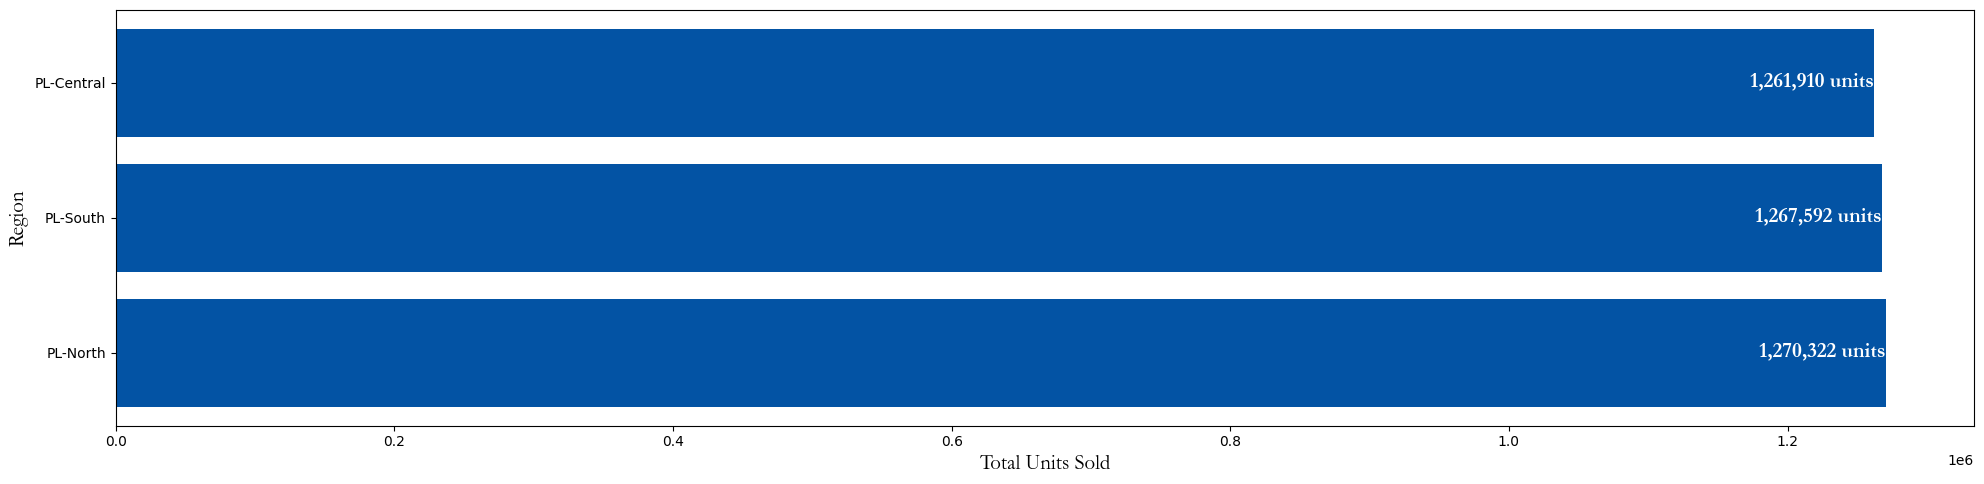

In [20]:
viz_monthly_performance_by_region()

### Performance by Category

In [21]:
def viz_monthly_performance_by_category():
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.groupby(by=["category"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    
    fig, ax = plt.subplots(figsize=(20, 5))
    bar_chart = ax.barh(transaction_data["category"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=15)
    ax.set_ylabel("Category", fontname="garamond", fontsize=15)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=15, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.show()

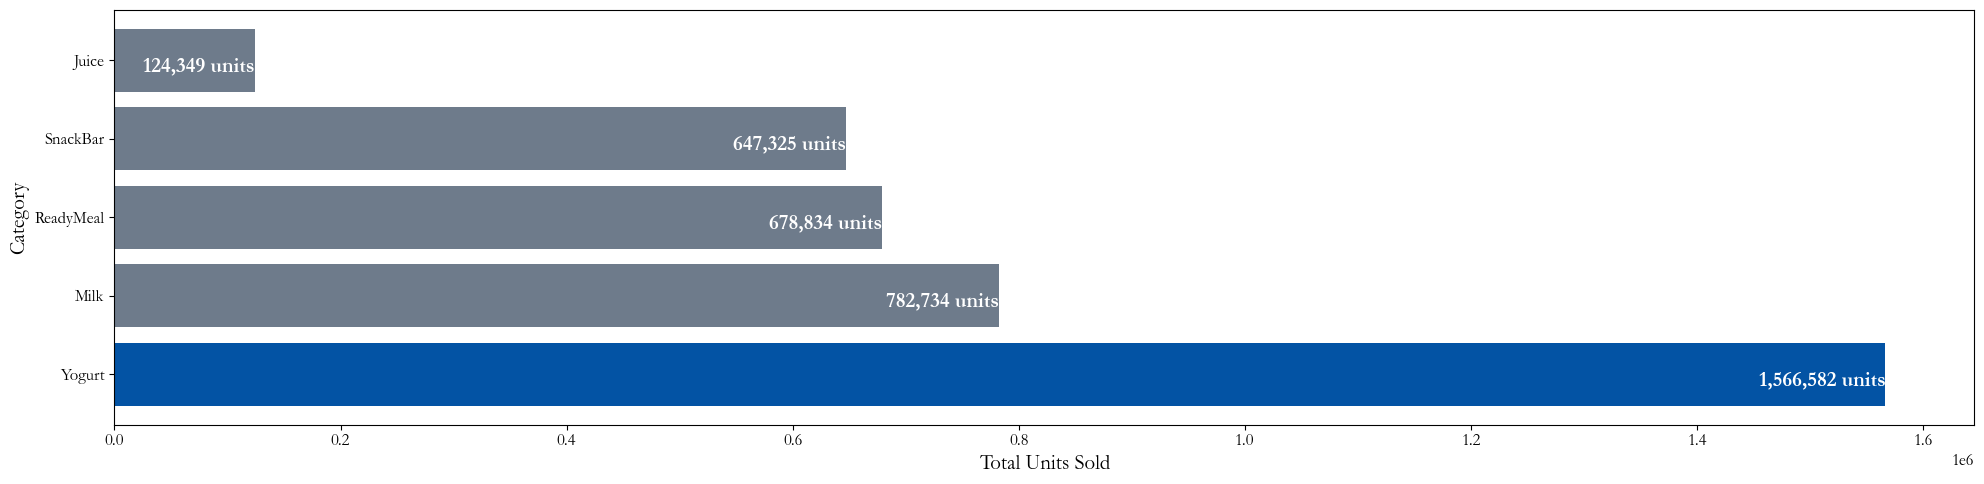

In [22]:
viz_monthly_performance_by_category()

### Performance by Brand

In [23]:
def viz_monthly_performance(group_parameter, category_filter_parameter: str = None):
    transaction_data = fmcg_dataset.copy()

    if category_filter_parameter is not None:
        transaction_data = transaction_data.loc[transaction_data["category"] == category_filter_parameter]
    
    transaction_data = transaction_data.groupby(by=group_parameter, as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B", "#6E7B8B"]
    
    fig, ax = plt.subplots(figsize=(20, 5))
    bar_chart = ax.barh(transaction_data[group_parameter], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=15)
    ax.set_ylabel(group_parameter.title() if len(group_parameter) > 3 else group_parameter.upper(), fontname="garamond", fontsize=15)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=13, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.show()

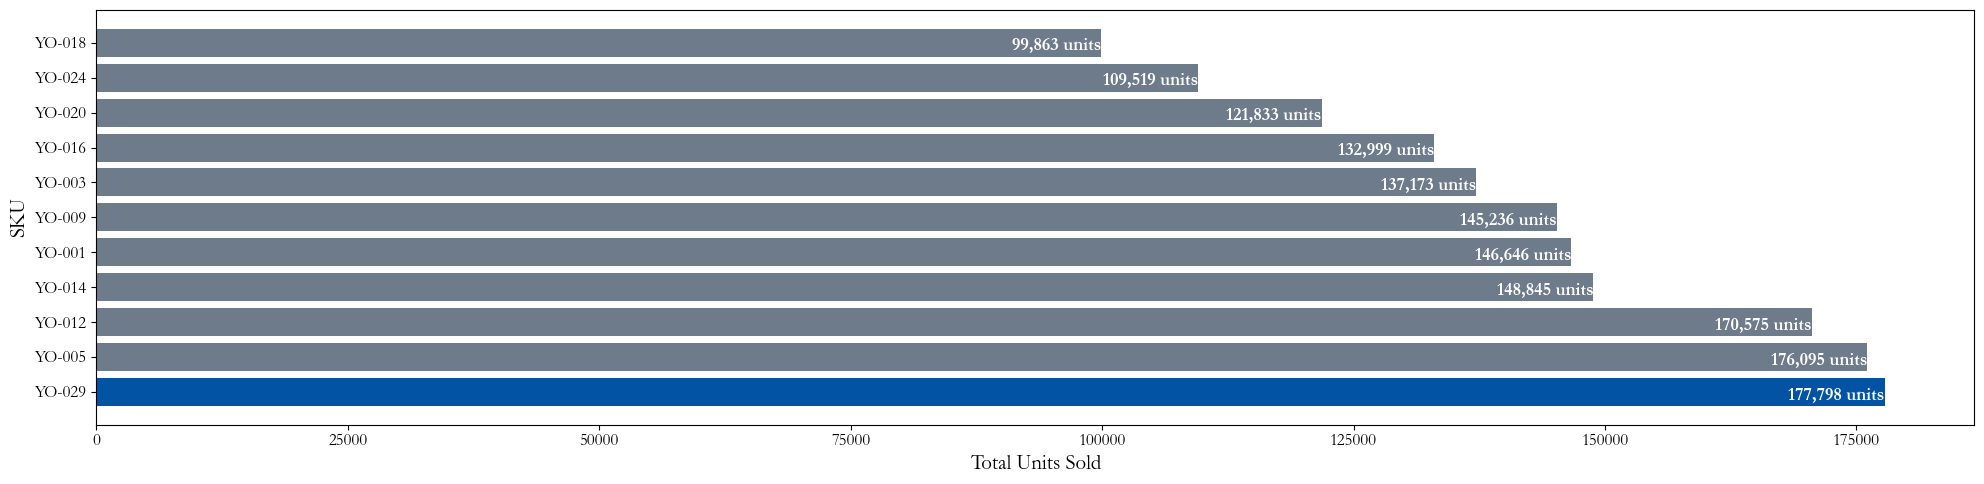

In [24]:
viz_monthly_performance("sku", "Yogurt")

### Performance by Channel

In [25]:
def viz_monthly_performance_by_channel():
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.groupby(by=["channel"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["units_sold"], ascending=False, inplace=True)
    colors = ["#0353A4", "#0353A4", "#0353A4"]
    
    fig, ax = plt.subplots(figsize=(20, 5))
    bar_chart = ax.barh(transaction_data["channel"], transaction_data["units_sold"], color=colors)
    ax.set_xlabel("Total Units Sold", fontname="garamond", fontsize=15)
    ax.set_ylabel("Channel", fontname="garamond", fontsize=15)

    for bar in bar_chart:
        width = bar.get_width()
        ax.text(width, bar.get_y() + (1 / len(bar_chart)), f"{width:,} units", ha="right", va="bottom", color="white", fontweight="bold", fontsize=15, fontname="garamond")

    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.show()

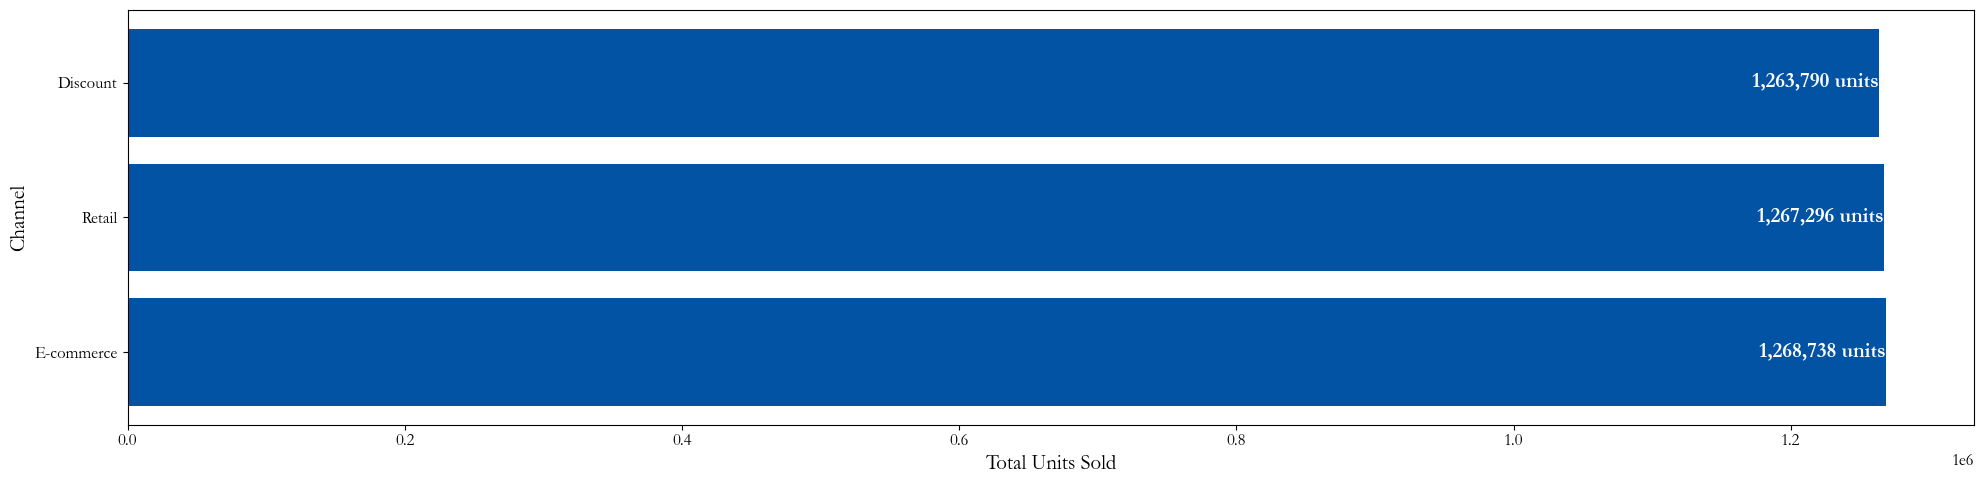

In [26]:
viz_monthly_performance_by_channel()

### Time-Series Visualization by Category

In [28]:
def time_series_viz_by_category(category: str, is_moving_average:bool = False, moving_average: int = 0):
    transaction_data = fmcg_dataset.copy()
    transaction_data = transaction_data.loc[transaction_data["category"] == category]
    transaction_data = transaction_data.groupby(by=["date", "season"], as_index=False)["units_sold"].sum()
    transaction_data.sort_values(by=["date"], inplace=True)
    
    fig, ax = plt.subplots(figsize=(20, 5))
    
    if is_moving_average:
        ax.plot(transaction_data["date"], transaction_data["units_sold"], label=f"{category} (daily)", alpha=.2, linewidth=2)
        
        if moving_average > 0:
            transaction_data[f"moving_average_{moving_average}"] = transaction_data["units_sold"].rolling(window=moving_average).mean().round(2)
            ax.plot(transaction_data["date"], transaction_data[f"moving_average_{moving_average}"], label=f"Smoothed ({moving_average}-days MA)", linewidth=.8)
        else:
            transaction_data["moving_average_3"] = transaction_data["units_sold"].rolling(window=3).mean().round(2)
            transaction_data["moving_average_7"] = transaction_data["units_sold"].rolling(window=7).mean().round(2)
            transaction_data["moving_average_14"] = transaction_data["units_sold"].rolling(window=14).mean().round(2)
            transaction_data["moving_average_30"] = transaction_data["units_sold"].rolling(window=30).mean().round(2)
            transaction_data["moving_average_60"] = transaction_data["units_sold"].rolling(window=60).mean().round(2)
            ax.plot(transaction_data["date"], transaction_data["moving_average_3"], label="Smoothed (3-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_7"], label="Smoothed (7-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_14"], label="Smoothed (14-days MA)", linewidth=.8)
            ax.plot(transaction_data["date"], transaction_data["moving_average_30"], label="Smoothed (30-days MA)", linewidth=.8)
    else:
        ax.plot(transaction_data["date"], transaction_data["units_sold"], label=f"{category} (daily)", linewidth=1)

    season_colors = {"Winter":"white", "Spring":"pink", "Summer":"yellow", "Autumn":"darkorange"}
    for season_block, group_data in transaction_data.groupby((transaction_data["season"] != transaction_data["season"].shift()).cumsum()):
        start_date = group_data["date"].iloc[0]
        end_date = group_data["date"].iloc[-1]

        if (end_date - start_date).days >= 20:
            season = group_data["season"].iloc[0]
            
            ax.axvspan(start_date, end_date, color=season_colors.get(season), alpha=0.3, zorder=0)
            text_x_position = start_date + (end_date - start_date) / 2
            text_y_position = ax.get_ylim()[0] + (ax.get_ylim()[1] + ax.get_ylim()[0]) * .65
            ax.text(text_x_position, text_y_position, season, ha="center", va="center", fontweight="regular")
    
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Units Sold", fontsize=15)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax.legend()
    ax.grid()
    plt.rcParams['font.family'] = 'garamond'
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.show()

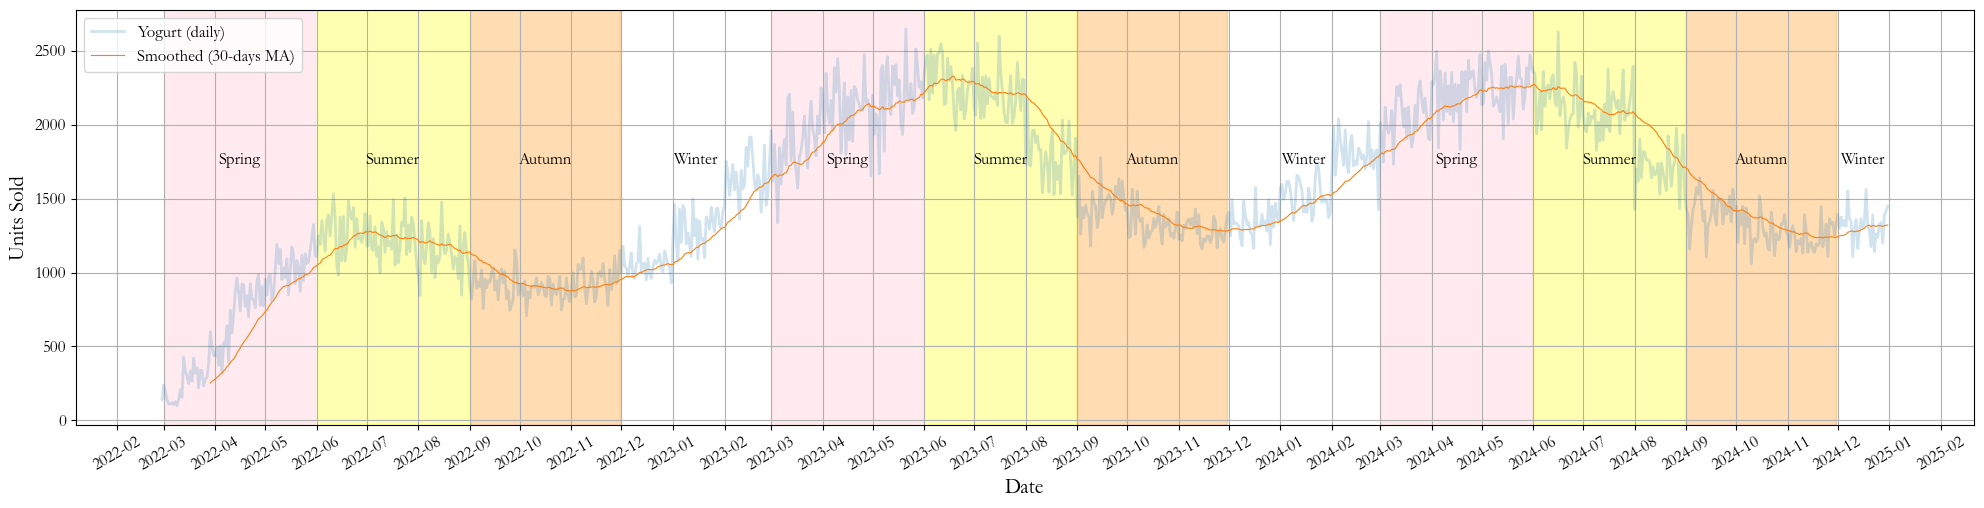

In [29]:
time_series_viz_by_category("Yogurt", True, 30)

### Stock Analysis

In [30]:
def analyze_stockout(category: str = None, region: str = None, channel: str = None) -> pd.DataFrame:
    stock_data = fmcg_dataset.copy()

    if category is not None:
        stock_data = stock_data.loc[stock_data["category"] == category]

    if region is not None:
        stock_data = stock_data.loc[stock_data["region"] == region]

    if channel is not None:
        stock_data = stock_data.loc[stock_data["channel"] == channel]

    stock_data = stock_data.loc[stock_data["stock_available"] == 0, 
            ["date", "stock_available", "category", "brand", "sku", "channel", "season", "is_weekend", "is_public_holiday", "region"]]
        
    stock_data.reset_index(drop=True, inplace=True)
    
    return stock_data

In [31]:
analyze_stockout("Yogurt", "PL-North", "Retail").groupby(by=["brand"]).size()

brand
YoBrand1    29
YoBrand2    46
YoBrand3    39
YoBrand4    47
dtype: int64

In [32]:
stockout_date = fmcg_dataset.loc[(fmcg_dataset["brand"] == "YoBrand4") & (fmcg_dataset["region"] == "PL-North") 
    & (fmcg_dataset["stock_available"] == 0) & (fmcg_dataset["channel"] == "Discount"), ["date", "year", "month", "season", "sub_season", "sku"]]
stockout_date.groupby(by=["sku"]).size()

sku
YO-009    19
YO-014    14
YO-029    23
dtype: int64

### Promotion Analysis

### YoY Performance

### MoM Performance

## Modelling and Forecasting by SKU

### Grouping Data

In [33]:
sku_data = fmcg_dataset.copy()
sku_data = sku_data.loc[(sku_data["sku"] == "YO-029") & (sku_data["region"] == "PL-North") & (sku_data["channel"] == "Retail")]
sku_data = sku_data.groupby(by=["date", "season"], as_index=False).agg(units_sold=("units_sold", "sum"),
                                                                       promotion_flag=("promotion_flag", "first"),
                                                                       price_unit=("price_unit", "first"),
                                                                       pack_type=("pack_type", "first"),
                                                                       delivery_days=("delivery_days", "first"),
                                                                       year=("year", "first"),
                                                                       month=("month", "first"),
                                                                       week=("week", "first"),
                                                                       day_of_the_month=("day_of_the_month", "first"),
                                                                       day_of_the_week=("day_of_the_week", "first"),
                                                                       is_weekend=("is_weekend", "first"),
                                                                       is_public_holiday=("is_public_holiday", "first"),
                                                                       sub_season=("sub_season", "first"))


### Filling Missing Dates

In [34]:
date_range = pd.date_range(start=sku_data["date"].min(), end=sku_data["date"].max(), freq='D')
date_range.difference(sku_data["date"]).dtype
sku_data = pd.concat([sku_data, pd.DataFrame(date_range.difference(sku_data["date"]), columns=["date"])], ignore_index=True)
sku_data.sort_values(by=["date"], inplace=True)
sku_data.reset_index(drop=True, inplace=True)

### Reapply Previous Functions for Feature Engineering

In [35]:
sku_data = chunking_date(sku_data)
sku_data = categorize_weekend(sku_data)
sku_data = season_month_mapping(sku_data)
sku_data["is_public_holiday"] = sku_data[["month", "day_of_the_month"]].apply(map_public_holiday, axis=1, args=(public_holidays_list,))
sku_data["units_sold"] = sku_data["units_sold"].fillna(0)
sku_data["units_sold"] = sku_data["units_sold"].astype(int)

### Defining the Value of Promotion Flag

This is a hard part because even though I can safely assume **missing dates mean there is no transaction** and **no transaction means no promotion**, still there is a possibility that the promotion was actually active but no sales. 

Therefore, I have no solid proof to tell whether **the promotion was actually active but no sales** or **no promotion in the first place**.

But I'm going to try to calculate the probability of promotion_flag == 0 or 1 based on the day of the week.

In [87]:
promotion_data = sku_data[["date", "day_of_the_week"]].loc[sku_data["promotion_flag"] == 1].groupby(by=["day_of_the_week"], as_index=False).count()
total_promotion_days = promotion_data["date"].sum()

promotion_data["probability"] = promotion_data["date"].apply(lambda x: x / total_promotion_days * 100).round(2)
promotion_data

,day_of_the_week,date,probability
0,Friday,18,12.95
1,Monday,23,16.55
2,Saturday,18,12.95
3,Sunday,27,19.42
4,Thursday,13,9.35
5,Tuesday,22,15.83
6,Wednesday,18,12.95


In [88]:
non_promotion_data = sku_data[["date", "day_of_the_week"]].loc[sku_data["promotion_flag"] == 0].groupby(by=["day_of_the_week"], as_index=False).count()
total_non_promotion_days = non_promotion_data["date"].sum()

non_promotion_data["probability"] = non_promotion_data["date"].apply(lambda x: x / total_non_promotion_days * 100).round(2)
non_promotion_data

,day_of_the_week,date,probability
0,Friday,109,14.71
1,Monday,107,14.44
2,Saturday,106,14.30
3,Sunday,102,13.77
4,Thursday,105,14.17
5,Tuesday,99,13.36
6,Wednesday,113,15.25


In [89]:
total_of_all_days = total_promotion_days + total_non_promotion_days
total_of_all_days

np.int64(880)

In [90]:
non_promotion_data["probability_non_promotion_given_day"] = non_promotion_data["date"].apply(lambda x: x / total_of_all_days * 100).round(2)
non_promotion_data

,day_of_the_week,date,probability,probability_non_promotion_given_day
0,Friday,109,14.71,12.39
1,Monday,107,14.44,12.16
2,Saturday,106,14.30,12.05
3,Sunday,102,13.77,11.59
4,Thursday,105,14.17,11.93
5,Tuesday,99,13.36,11.25
6,Wednesday,113,15.25,12.84


In [91]:
promotion_data["probability_promotion_given_day"] = promotion_data["date"].apply(lambda x: x / total_of_all_days * 100).round(2)
promotion_data

,day_of_the_week,date,probability,probability_promotion_given_day
0,Friday,18,12.95,2.05
1,Monday,23,16.55,2.61
2,Saturday,18,12.95,2.05
3,Sunday,27,19.42,3.07
4,Thursday,13,9.35,1.48
5,Tuesday,22,15.83,2.50
6,Wednesday,18,12.95,2.05


The probability of **promotion_flag == 0** is likely to happen relative to **promotion_flag == 1**.
Therefore, I'm going to **set all NaN values in promotion_flag to 0**

In [96]:
sku_data["promotion_flag"] = sku_data["promotion_flag"].fillna(0).astype(int)

### Defining the Value of Pack Type

Since there is no way I can tell what kind of pack type on that day that has no sales. I think it will ruin the data if I try to assume based on nothing, and will be safe to just drop the column. 

In [103]:
sku_data.drop(["pack_type"], axis=1, inplace=True)

### Defining the Value of Price Unit

Originally, I was going to also add the pack type as the parameter for the calculation. Since I already dropped the pack_type column, I will just use the median price_unit grouped by year and month.

In [110]:
sku_data["price_unit"] = sku_data["price_unit"].fillna(sku_data.groupby(["year", "month"])["price_unit"].transform("median")).round(2)

### Defining the Value of Delivery Days

The same also goes with delivery_days. Since I already dropped the pack_type column, I will just use the median delivery_days grouped by year and month.

In [112]:
sku_data["delivery_days"] = sku_data["delivery_days"].fillna(sku_data.groupby(["year", "month"])["delivery_days"].transform("median")).round(2)

In [114]:
sku_data.sort_values(by=["date"], inplace=True)
sku_data.reset_index(drop=True, inplace=True)
sku_data

,date,season,units_sold,promotion_flag,price_unit,delivery_days,year,month,week,day_of_the_month,day_of_the_week,is_weekend,is_public_holiday,sub_season
0,2022-02-28,Winter,17,0,4.52,5.0,2022,February,9,28,Monday,False,False,Late-Winter
1,2022-03-01,Spring,42,0,2.40,4.0,2022,March,9,1,Tuesday,False,False,Early-Spring
2,2022-03-02,Spring,20,0,2.68,3.0,2022,March,9,2,Wednesday,False,False,Early-Spring
3,2022-03-03,Spring,0,0,6.30,3.0,2022,March,9,3,Thursday,False,False,Early-Spring
4,2022-03-04,Spring,18,0,4.32,3.0,2022,March,9,4,Friday,False,False,Early-Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,2024-12-27,Winter,26,1,4.02,4.0,2024,December,52,27,Friday,False,False,Early-Winter
1034,2024-12-28,Winter,14,0,3.93,4.0,2024,December,52,28,Saturday,False,False,Early-Winter
1035,2024-12-29,Winter,20,0,8.10,4.0,2024,December,52,29,Sunday,False,False,Early-Winter
1036,2024-12-30,Winter,0,0,4.92,3.0,2024,December,1,30,Monday,False,False,Early-Winter


### Adding Several Features

In [115]:
sku_data.sort_values(by=["date"], inplace=True)
sku_data.reset_index(drop=True, inplace=True)
sku_data["lag_7"] = sku_data["units_sold"].shift(7).fillna(0)
sku_data["lag_7"] = sku_data["lag_7"].astype(int)
sku_data["moving_average_7"] = sku_data["units_sold"].rolling(window=7).mean().fillna(0).round(2)

### Changing Type of Several Columns

In [117]:
sku_data["month"] = sku_data["month"].astype("category")
sku_data["day_of_the_week"] = sku_data["day_of_the_week"].astype("category")
sku_data["season"] = sku_data["season"].astype("category")
sku_data["sub_season"] = sku_data["sub_season"].astype("category")
sku_data.reset_index(drop=True, inplace=True)

### Train-Test Data Split

In [144]:
train = sku_data.loc[sku_data["date"] < "2024-12-01"]
test = sku_data.loc[sku_data["date"] >= "2024-12-01"]

### Train

In [145]:
FEATURES = ["month", "week", "day_of_the_month", "day_of_the_week", "season", "sub_season", "is_weekend", 
            "is_public_holiday", "price_unit", "promotion_flag", "delivery_days", "lag_7", "moving_average_7"]

TARGET = "units_sold"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [146]:
regressor = xgb.XGBRegressor(base_score=.5, booster="gbtree", 
                             n_estimators=10000, early_stopping_rounds=100,
                             objective="reg:squarederror", max_depth=200, 
                             learning_rate=0.001, enable_categorical=True)

regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:24.67293	validation_1-rmse:16.74994
[100]	validation_0-rmse:22.67438	validation_1-rmse:15.74931
[200]	validation_0-rmse:20.86370	validation_1-rmse:14.84369
[300]	validation_0-rmse:19.21604	validation_1-rmse:14.04399
[400]	validation_0-rmse:17.71144	validation_1-rmse:13.48489
[500]	validation_0-rmse:16.33455	validation_1-rmse:12.92096
[600]	validation_0-rmse:15.07821	validation_1-rmse:12.38814
[700]	validation_0-rmse:13.92952	validation_1-rmse:11.87614
[800]	validation_0-rmse:12.87762	validation_1-rmse:11.41240
[900]	validation_0-rmse:11.90817	validation_1-rmse:10.98603
[1000]	validation_0-rmse:11.01894	validation_1-rmse:10.60646
[1100]	validation_0-rmse:10.20281	validation_1-rmse:10.26637
[1200]	validation_0-rmse:9.45094	validation_1-rmse:10.01184
[1300]	validation_0-rmse:8.75789	validation_1-rmse:9.78106
[1400]	validation_0-rmse:8.11394	validation_1-rmse:9.65222
[1500]	validation_0-rmse:7.52566	validation_1-rmse:9.55655
[1600]	validation_0-rmse:6.98357	validation

,objective,'reg:squarederror'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,100
,enable_categorical,True
,eval_metric,None


### Feature Importance

<Axes: title={'center': 'Feature Importance'}>

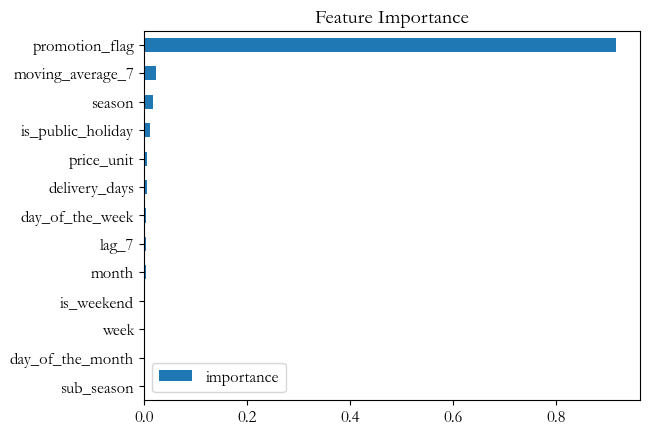

In [147]:
feature_importance = pd.DataFrame(data=regressor.feature_importances_, 
                                  index=regressor.feature_names_in_, 
                                  columns=["importance"])

feature_importance.sort_values("importance").plot(kind="barh", title="Feature Importance")

### Test

C:\Users\hisma\AppData\Local\Temp\ipykernel_21308\1107234810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = regressor.predict(X_test)


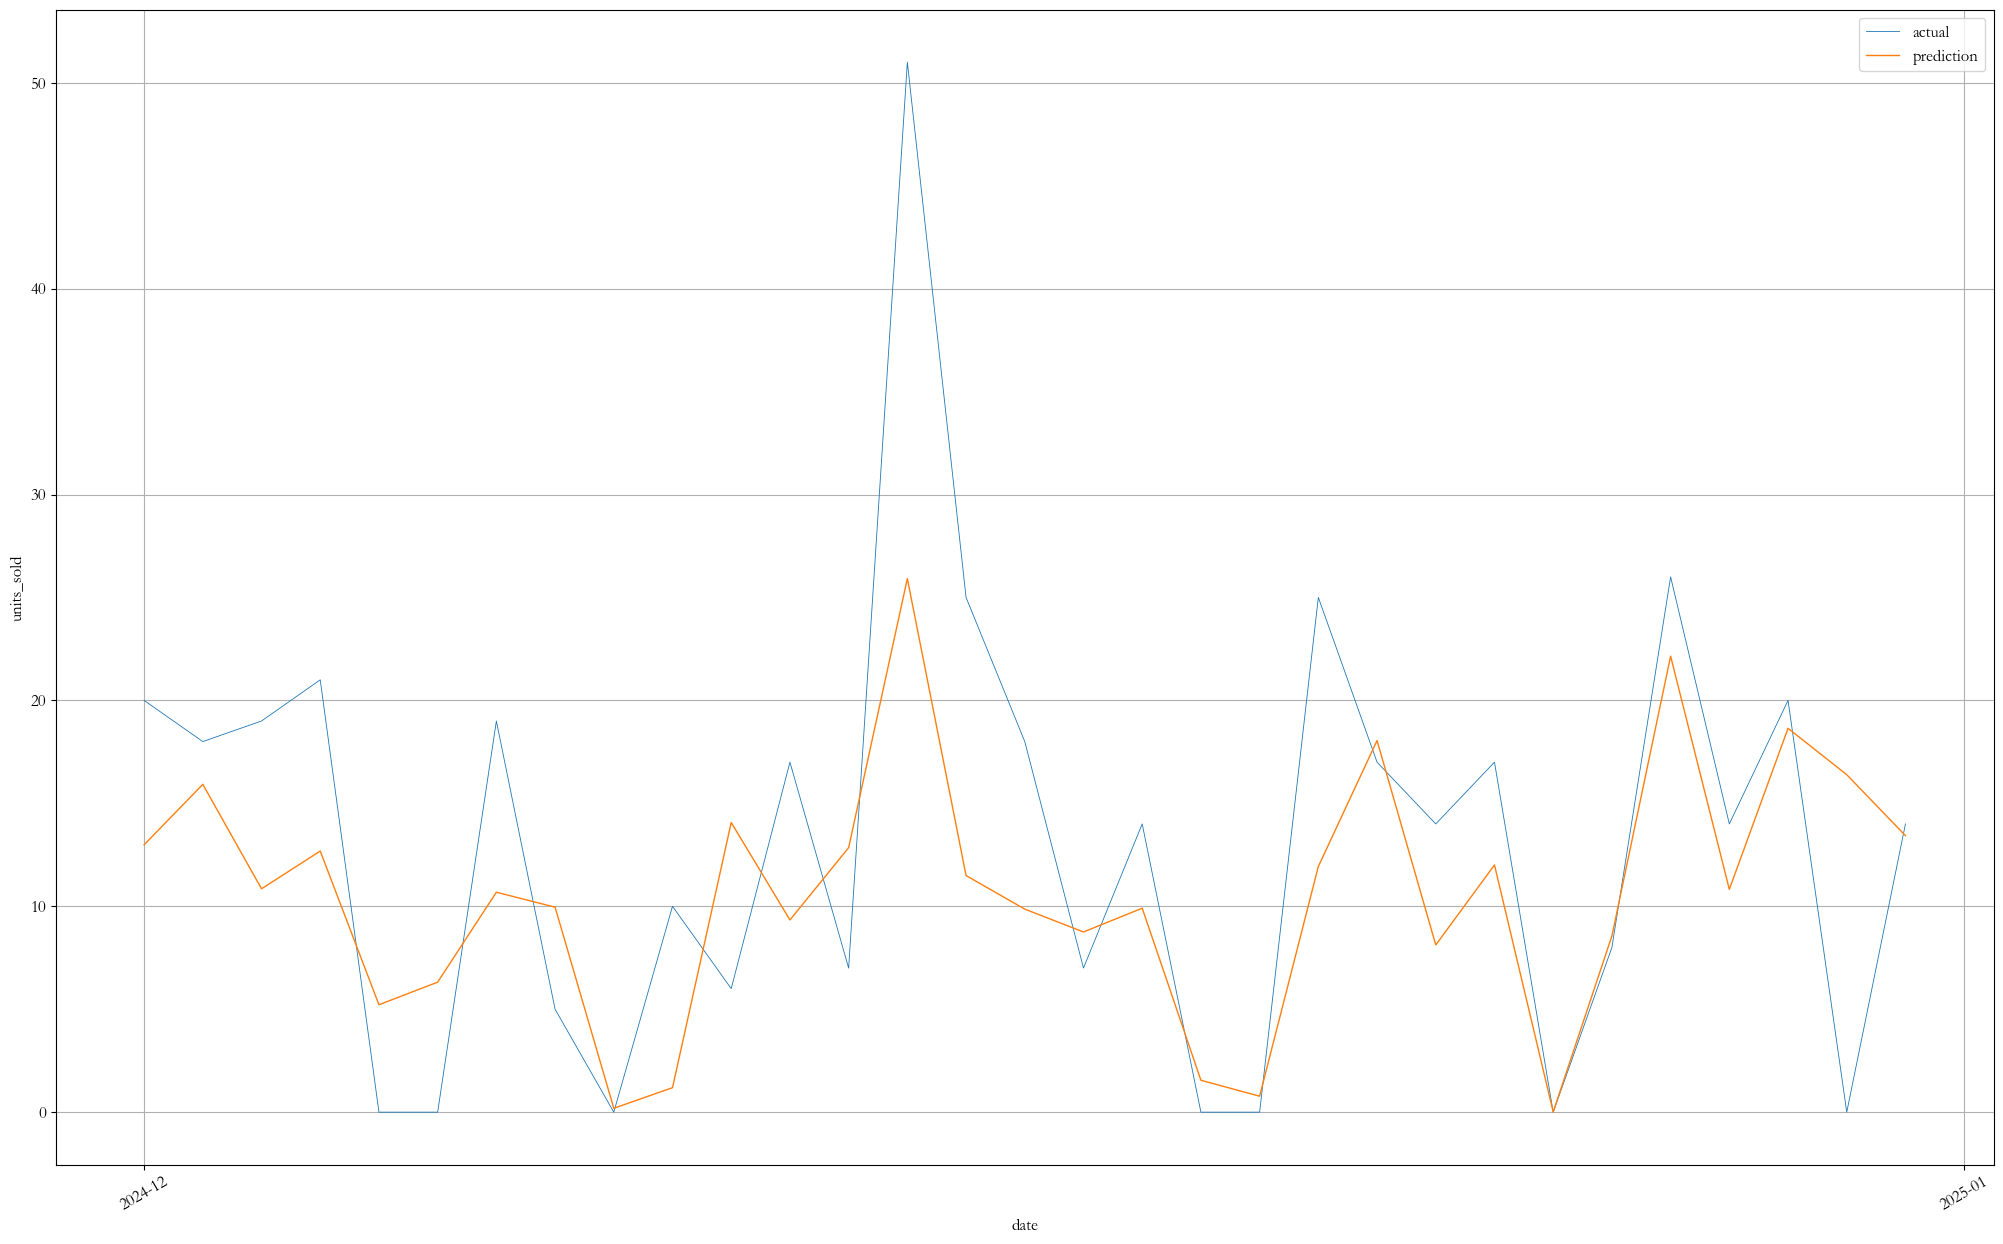

In [148]:
test["prediction"] = regressor.predict(X_test)

fig, ax = plt.subplots(figsize=(25, 15))

ax.plot(test["date"], test["units_sold"], linewidth=.6, label="actual")
ax.plot(test["date"], test["prediction"], linewidth=1.0, label="prediction")
ax.set_xlabel("date")
ax.set_ylabel("units_sold")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.legend()
ax.grid(True)
plt.xticks(rotation=30)
plt.show()

In [149]:
round(mean_absolute_error(test["units_sold"], test["prediction"]), 2)

6.02

In [150]:
round(mean_squared_error(test["units_sold"], test["prediction"]), 2)

64.96

In [151]:
round(root_mean_squared_error(test["units_sold"], test["prediction"]), 2)

8.06